# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import time

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

## Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

from src.feature_selection.functions import shap_feature_selection, process_fi

from src.utils.functions import adjust_fi

from src.model.functions import run_model_experiment

from src.plots.functions import plots_metrics

## Parameters

In [5]:
seed = 123
iterations = 10
gamma = 0.146
n_estimators_list = [25, 50, 75, 100, 125, 150, 175, 200]
np.random.seed(seed)

dataset_id = 'cardio'
df = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)

In [6]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,y
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,0.0
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,0.0
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,0.0
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,0.0
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,0.0


### Paths

In [7]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

## Features selected

### Generate/Load data

In [8]:
# Simulated data and settings
gamma, iterations = 0.146, 10

# Split the DataFrame into features (X) and target (y)
X = df.drop('y', axis=1)  # Features (all columns except 'y')
y = df['y']  # Target (the 'y' column)

# Split into training and testing sets
xtr, xte , ytr, yte = train_test_split(X, y, test_size=0.1, random_state=seed)

### Generate the model

In [9]:
# Initialize and train the IsolationForest model
model = IsolationForest(**hyper, random_state=seed)
model.fit(xtr)

IsolationForest(contamination=0.1, max_samples=256, random_state=123)

### Features names

In [10]:
feature_names = np.array(X.columns.tolist())

### Selection process

In [11]:
# Example usage:
selected_features_df = shap_feature_selection(model, xtr, xte, feature_names, agnostic=False)
fi_shap_all = process_fi(selected_features_df, 10)
fi_shap_all.to_parquet(path_fi_shap)

In [12]:
fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all = adjust_fi(fi_shap_all)
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,2,0.468723,16.813538,9.523810,"[Col10, Col16]"
2,4,0.825878,29.625005,19.047619,"[Col10, Col16, Col4, Col20]"
3,6,1.133335,40.653750,28.571429,"[Col10, Col16, Col4, Col20, Col2, Col21]"
4,8,1.412838,50.679809,38.095238,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."
5,10,1.673762,60.039378,47.619048,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."
6,12,1.928412,69.173922,57.142857,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."
7,15,2.282359,81.870298,71.428571,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."
8,17,2.493922,89.459259,80.952381,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."
9,21,2.787774,100.000000,100.000000,"[Col10, Col16, Col4, Col20, Col2, Col21, Col7,..."


### Generate data

In [13]:
# Capture the start time
start_time = datetime.datetime.now()

results = run_model_experiment(fi_shap_all, df, hyper, 
                     gamma=gamma, iterations=iterations, 
                     n_estimators_list=n_estimators_list, seed=seed, 
                     dataset_id=dataset_id)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")

2024-08-29 15:05:35,736 - INFO - Starting experiment with 2 features.
2024-08-29 15:05:35,743 - INFO - Starting model training with 2 features and 25 estimators.
2024-08-29 15:05:41,757 - INFO - Starting model training with 2 features and 50 estimators.
2024-08-29 15:05:43,226 - INFO - Starting model training with 2 features and 75 estimators.
2024-08-29 15:05:45,804 - INFO - Starting model training with 2 features and 100 estimators.
2024-08-29 15:05:48,314 - INFO - Starting model training with 2 features and 125 estimators.
2024-08-29 15:05:51,432 - INFO - Starting model training with 2 features and 150 estimators.
2024-08-29 15:05:55,051 - INFO - Starting model training with 2 features and 175 estimators.
2024-08-29 15:05:59,350 - INFO - Starting model training with 2 features and 200 estimators.
2024-08-29 15:06:04,326 - INFO - Starting experiment with 4 features.
2024-08-29 15:06:04,328 - INFO - Starting model training with 4 features and 25 estimators.
2024-08-29 15:06:05,301 - I

Duration: 0:05:14.518883


In [14]:
results.to_parquet(path_shap)

In [18]:
results

,dataset_id,n_feat,n_features_cum_shap_percentage,n_estimators,f1-score,recall,precision,roc_auc,smli,smli_all
0,cardio,2,16.813538,25,0.288344,0.291925,0.284848,0.606566,0.998188,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,cardio,2,16.813538,50,0.288344,0.291925,0.284848,0.605285,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,cardio,2,16.813538,75,0.289231,0.291925,0.286585,0.605828,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,cardio,2,16.813538,100,0.292835,0.291925,0.293750,0.606242,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,cardio,2,16.813538,125,0.288344,0.291925,0.284848,0.606008,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...
67,cardio,21,100.000000,100,0.539877,0.546584,0.533333,0.931234,0.718160,"[0.7708913864032053, 0.6525560107720165, 0.623..."
68,cardio,21,100.000000,125,0.546012,0.552795,0.539394,0.933917,0.744587,"[0.7798144367367671, 0.715427128198026, 0.6891..."
69,cardio,21,100.000000,150,0.552147,0.559006,0.545455,0.934465,0.761534,"[0.8244300995160989, 0.6983417793113602, 0.710..."
70,cardio,21,100.000000,175,0.552147,0.559006,0.545455,0.933830,0.771810,"[0.8215364037671029, 0.7221195499378703, 0.720..."


2024-08-29 15:11:46,116 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 15:11:46,131 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 15:11:46,256 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 15:11:46,271 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 15:11:46,385 - INFO - Using categorical units to plot a list of strings that are all parsable as 

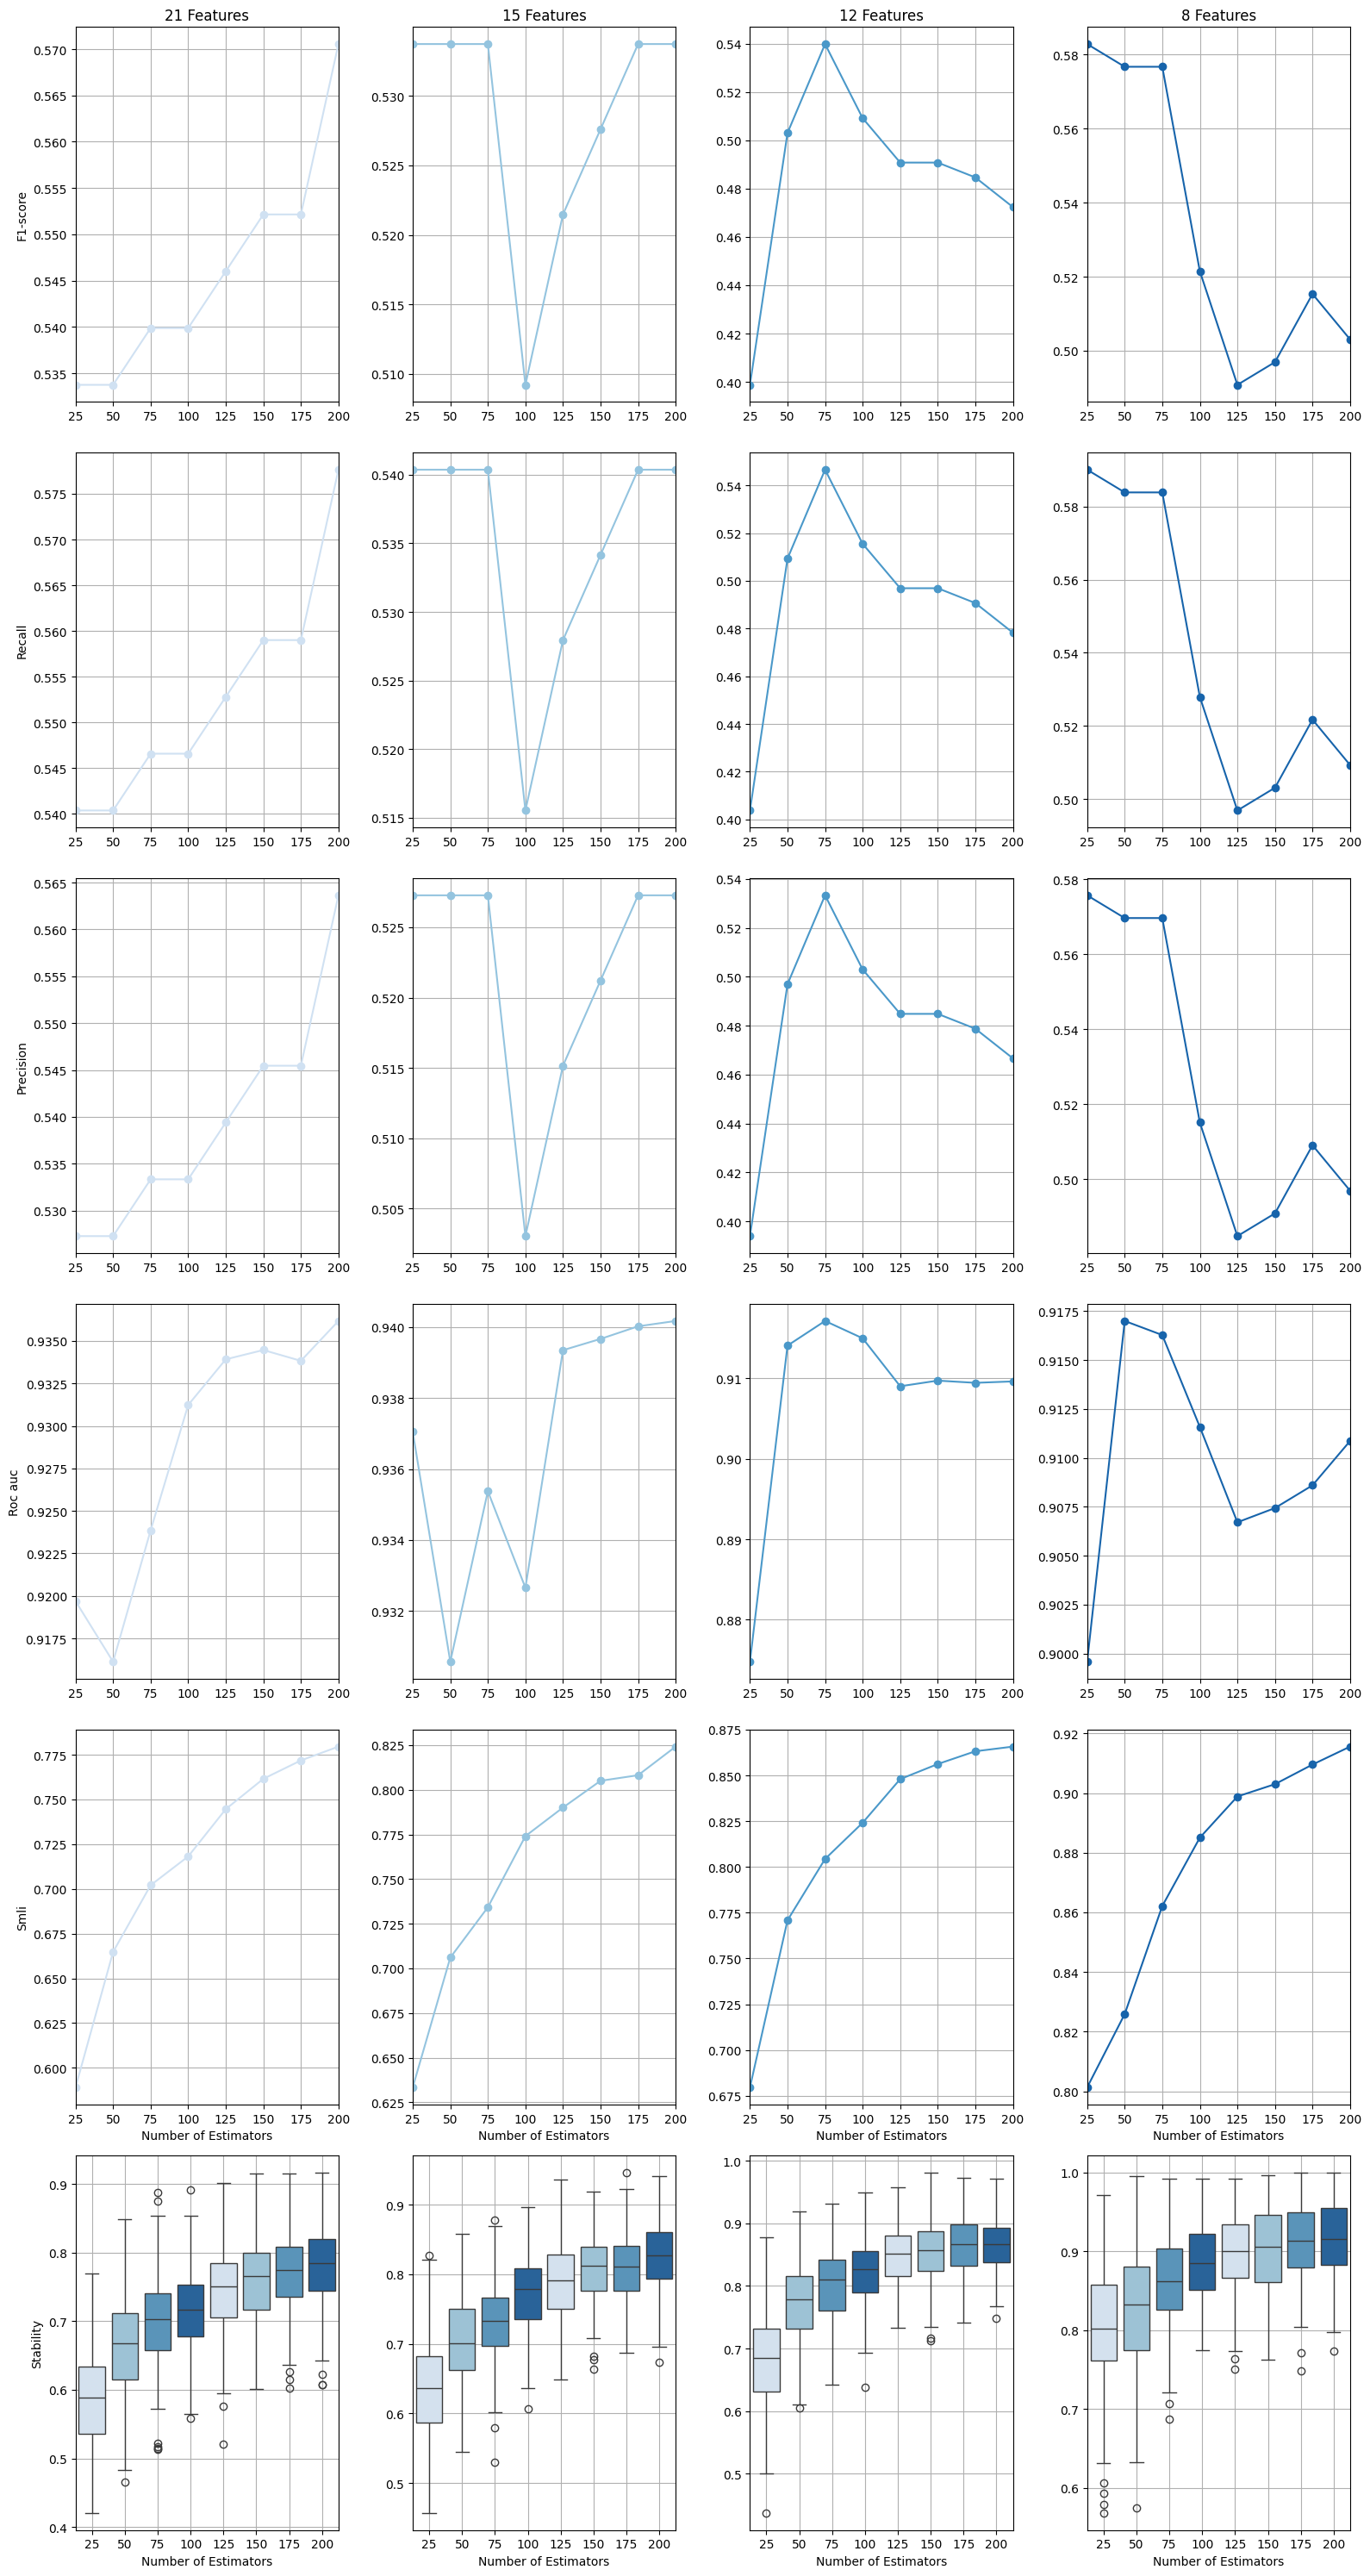

In [17]:
plots_metrics(results, 
              feat_imp=[100, 80, 75, 50],
              metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'])